# NUS Fintech Society: Stock Market Prediction Project (Part 2)
Done by: Samuel Khoo, Darren Lim, Tan Qing Lin, Leonard Tan

To predict the DJIA adjusted close price, we will be implementing a LSTM (Long Short-Term Memory) neural network. It a type of recurrent neural network that generally has higher predictive accuracy than normal neural networks, as they can learn long-term dependencies.

Introduction to RNN and LSTM: https://towardsdatascience.com/recurrent-neural-networks-and-lstm-4b601dd822a5

## Table of contents:
### 1. Loading of packages and datasets
### 2. Preparing the data for LSTM
### 3. Training the model
### 4. Test
### 5. Results
    5.1 Results table
    5.2 Results visualization

# 1. Loading of packages and datasets
You must have Keras installed with either the Tensorflow or Theano backend.

In [1]:
import numpy as np
import os 
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
#To prevent the kernel from dying
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
dataset = pd.read_csv('DJIA_features.csv', header=0, index_col='Date')
values = dataset.values

In [4]:
dataset.head()

,Adj Close,Volume,Label,DJIA_news_sentiment,Reddit_news_sentiment
Date,,,,,
2008-08-08,11734.320312,212830000,0,-0.228471,-0.058365
2008-08-11,11782.349609,183190000,1,-0.094220,-0.033574
2008-08-12,11642.469727,173590000,0,-0.147493,-0.052527
2008-08-13,11532.959961,182550000,0,-0.079888,-0.003060
2008-08-14,11615.929688,159790000,1,-0.124056,-0.031708


# 2. Preparing the data for LSTM
Our dataset isn't exactly ready for training yet. 

We need to convert the multi-variate time series to a supervised learning problem. 

Furthermore, as the inputs are of varying magnitude, there is a need to conduct feature scaling.

Lastly, we need to reshape the input data into a 3D input array.

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True) #need to change this when we add new features
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.440894   0.306702        0.0   0.282443   0.306648  0.444976
2   0.444976   0.262232        1.0   0.593187   0.528987  0.433087
3   0.433087   0.247828        0.0   0.469878   0.359004  0.423780
4   0.423780   0.261271        0.0   0.626361   0.802645  0.430832
5   0.430832   0.227123        1.0   0.524128   0.545717  0.434569


In [6]:
# split into train and test sets
values = reframed.values
n_train_days = len(dataset.loc[dataset.index < '2014-12-31'])
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1610, 1, 5) (1610,) (378, 1, 5) (378,)


# 3. Training the model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1610 samples, validate on 378 samples
Epoch 1/50
 - 2s - loss: 0.3847 - val_loss: 0.6655
Epoch 2/50
 - 0s - loss: 0.2124 - val_loss: 0.4399
Epoch 3/50
 - 0s - loss: 0.1769 - val_loss: 0.3426
Epoch 4/50
 - 0s - loss: 0.1798 - val_loss: 0.3105
Epoch 5/50
 - 0s - loss: 0.1737 - val_loss: 0.2955
Epoch 6/50
 - 0s - loss: 0.1634 - val_loss: 0.2769
Epoch 7/50
 - 0s - loss: 0.1537 - val_loss: 0.2563
Epoch 8/50
 - 0s - loss: 0.1438 - val_loss: 0.2339
Epoch 9/50
 - 0s - loss: 0.1334 - val_loss: 0.2088
Epoch 10/50
 - 0s - loss: 0.1234 - val_loss: 0.1847
Epoch 11/50
 - 0s - loss: 0.1128 - val_loss: 0.1624
Epoch 12/50
 - 0s - loss: 0.1011 - val_loss: 0.1395
Epoch 13/50
 - 0s - loss: 0.0879 - val_loss: 0.1120
Epoch 14/50
 - 0s - loss: 0.0745 - val_loss: 0.0824
Epoch 15/50
 - 0s - loss: 0.0608 - val_loss: 0.0558
Epoch 16/50
 - 0s - loss: 0.0486 - val_loss: 0.0397
Epoch 17/5

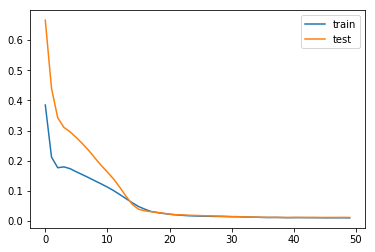

In [7]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# 4. Test

In [8]:
# predicting the test data
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 184.751


# 5. Results

## 5.1 Results table

In [15]:
#Subset original dataset for test period
test_dataset = dataset.loc[dataset.index >= '2015-01-02']
test_dataset_df = pd.DataFrame(test_dataset)

In [16]:
#Convert predicted values into dataframe
prediction_df = pd.DataFrame(inv_yhat)

#Add dates to prediction dataframe
test_dates = list(test_dataset.index)
prediction_df['Date'] = test_dates
prediction_df.columns = ['Prediction', 'Date']

#Set Date as index (for merging purposes)
prediction_df = prediction_df.set_index('Date')

In [17]:
#Merge the 2 datasets
final_dataset = pd.concat([test_dataset_df, prediction_df], axis = 1)

#Keep only the required columns
final_dataset = final_dataset[['Adj Close', 'Prediction']]

#Push Date out as a column (for plotting purposes)
final_dataset = final_dataset.reset_index()

#Covert Date to date type
final_dataset['Date'] = pd.to_datetime(final_dataset['Date'])
final_dataset.head()

,Date,Adj Close,Prediction
0,2015-01-02,17832.990234,17881.537109
1,2015-01-05,17501.650391,17870.994141
2,2015-01-06,17371.640625,17502.755859
3,2015-01-07,17584.519531,17473.371094
4,2015-01-08,17907.869141,17601.794922


## 5.2 Results visualization

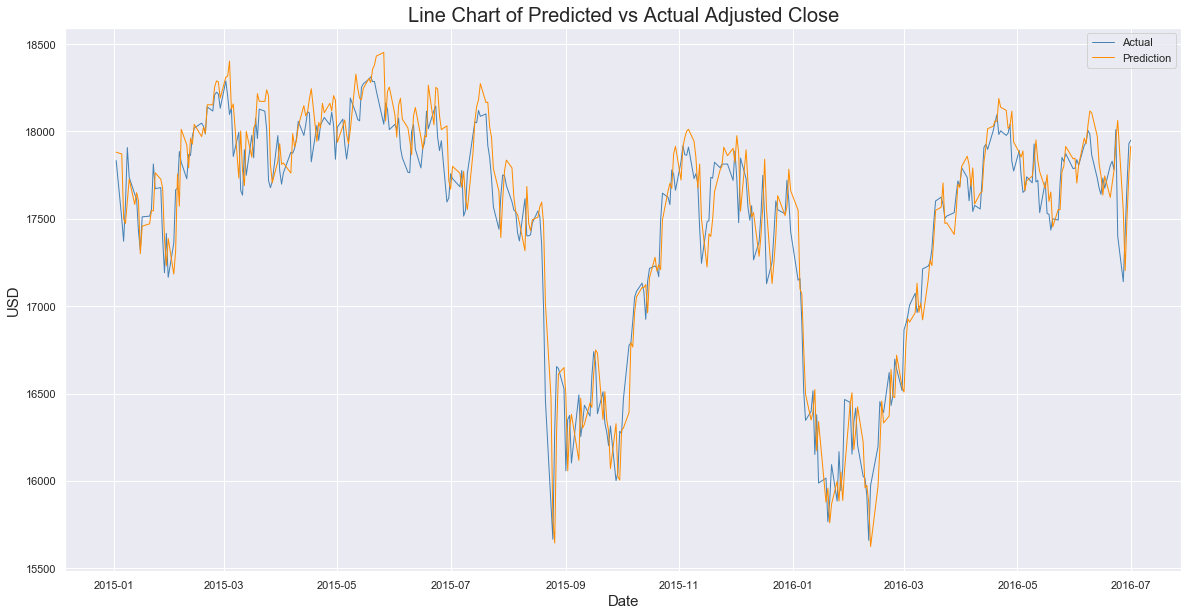

In [18]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(20,10)})

results = sns.lineplot(x="Date", y="Adj Close", data=final_dataset, color = 'steelblue', linewidth= 1, label = 'Actual')
results = sns.lineplot(x="Date", y="Prediction", data=final_dataset, color = 'darkorange', linewidth= 1, label = 'Prediction')
results.axes.set_title("Line Chart of Predicted vs Actual Adjusted Close",fontsize=20)
results.set_xlabel("Date", fontsize=15)
results.set_ylabel("USD", fontsize=15)
results.legend()

pyplot.show()